# LeNet-5 vs VGG16

VGG: Very Deep Convolutional Networks for Large-Scale Image Recognition: Trained on ImageNet (Transfer Learning)

LeNet-5, from the paper Gradient-Based Learning Applied to Document Recognition, is a very efficient convolutional neural network for handwritten character recognition.

## 1. Importing various modules

In [ ]:
# data visualisation
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# file handling
import pickle

# support sci-kit learn modules
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
# core
from keras import backend as K
from keras.datasets import cifar10

# DL libraraies
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# specifically for cnn
from keras.layers import Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD, Adam

# opencv for image handling
import cv2

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('ignore')

print("The required Keras libraries are installed...")

The required Keras libraries are installed...


## 2. Preparing the Data: CIFAR-10

CIFAR-10 is an established computer vision dataset used for object recognition. It is a subset of 80 million tiny image datasets. It was collected by Alex Krizhevsky, Vinod Nair and Geoffrey Hinton.

Like MNIST, CIFAR-10 is considered another standard benchmark dataset for image classification in the computer vision and machine learning literature.

While it is fairly easy to train a model that achieves 97 percent classification accuracy on MNIST, it is quite difficult to obtain such a model for CIFAR-10.

The difficulty stems from the dramatic variability in the way objects appear. For example, we cannot consider a region containing a red pixel in a given coordinate range as a truck, car, deer or ship. This pixel could be in any of these objects.

The CIFAR-10 data consists of 60,000 32x32 color images for 10 classes, with 6000 images per class. The creators of the dataset divided the data into 50,000 training images and 10,000 test images.

Label classes in the dataset:

* airplane: aeroplano ✈  
* car: automobile 🏎
* bird: uccello 🐦
* cat: gatto 🐱
* deer: cervo 🦌
* dog: cane 🐶
* frog: rana 🐸
* horse: cavallo 🐴
* ship: nave 🛳
* truck: camion 🚚  

Classes are made up of completely mutually exclusive samples. That is, there is no overlap between cars and trucks. "Cars" includes sedans, SUVs, etc. "Truck" includes only large trucks. For example, it does not include pickup trucks.

### 2.1. Transferring CIFAR-10 Data Set to Kaggle Environment

The inclusion of the dataset in the study environment is given on the page with the dataset as follows.
#### *I've tried to run the official CIFAR10 code, but I encountered the problem of downloading the data set too slowly and server name not resolved.*


In [ ]:
#  write your own code to load the dataset.
def load_batch(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
        data = d['data']
        labels = d['labels']
        data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_data(path ='data/cifar-10-batches-py'):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

In [ ]:

(X_train, y_train), (X_test, y_test) = cifar10.load_data() #load_data('/kaggle/input/cifar10-python/cifar-10-batches-py')
print("CIFAR-10 dataset loaded...")

class_names = ["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]

170508288/170498071 [==============================] - 3s 0us/step
CIFAR-10 dataset loaded...


In [ ]:
X_train.shape

(50000, 32, 32, 3)

### 2.2. Visualization of the CIFAR-10 Data Set

It is useful to see what kind of images are in the dataset. The creators of the dataset have ensured that only the relevant object is in the image. Even if the backgrounds are different and complex, the images are created in such a way that only the relevant object is in the image.

**The add_side function below takes three parameters; images, side_type, side_size.**

* images: List holding the images
* side_type: Holds the edge type to be added to images. It should hold "horizontal" for horizontal edge and "vertical" for vertical edge
* side_size: Sets the size of the edge to be added

The function adds vertical or horizontal edges to the image list according to the side_type parameter value.

In [ ]:
def add_side(images, side_type, side_size=1):
        # List to keep edge-added images
        new_images = list()
        # Retrieving images from the image list
        for image in images:
            if side_type == "horizontal":
                # Creating an edge at the height and desired size of the image
                side = np.ones((image.shape[0], side_size, image.ndim), dtype=image.dtype)*255
                image=np.hstack((image,side))
            elif side_type == "vertical":
                side=np.ones((side_size, image.shape[1], image.ndim), dtype=image.dtype)*255
                image=np.vstack((image,side))

            new_images.append(image)
        return new_images

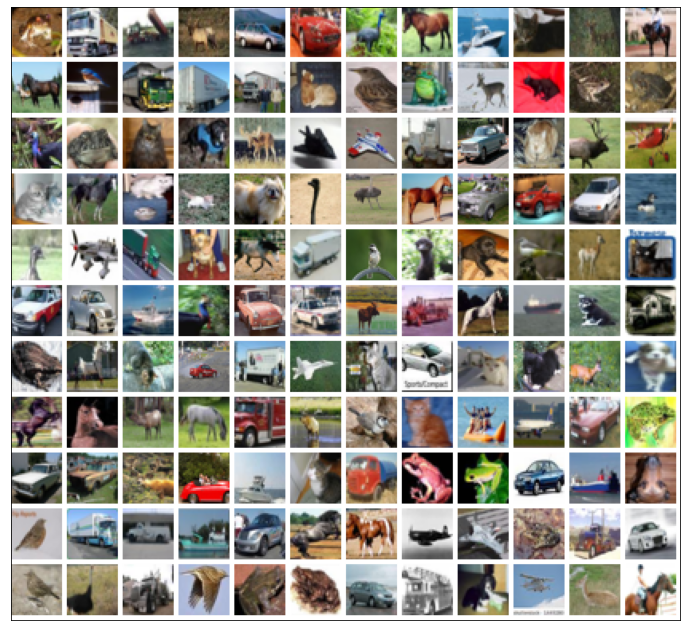

In [ ]:
rows = []
step = 12

# horizontal images
for i in range(0, 130, step):
    horizontal_sided_images = add_side(X_train[i:i+step], side_type="horizontal", side_size=3)
    row = np.hstack((horizontal_sided_images))
    rows.append(row)

# vertical ones
vertical_sided_images = add_side(rows, side_type="vertical",side_size=3)
gallery = np.vstack((vertical_sided_images))

# create plot
plt.figure(figsize=(12,12))
plt.imshow(gallery)
plt.xticks([])
plt.yticks([])

plt.show()

## 3 Using VGGNet Models on CIFAR-10¶
In machine learning applications, one of the most important steps is to format the data set according to the model. Since the Cifar10 dataset is a professionally created dataset, it does not need much pre-processing. However, there are still a few pre-processing steps that need to be done.

### 3.1. Preparation of the CIFAR-10 Data Set

As with many machine learning methods, deep network models work better with scaled data. The scaling process for images is called normalization. For Cifar10 images, normalization can be performed by dividing each pixel by 255. Below is the normalization of the training and test images.

In [ ]:
X_train = X_train.astype(np.float32)/255.0
X_test= X_test.astype(np.float32)/255.0
print("Normalization performed...")

Normalization performed...


Giving the list of target variables to Keras deep network models is slightly different from giving the list of target variables to sklearn models.
While sklearn models can give the list of target variables in one dimension, keras models need to be *OneHot coded*. In **OneHot** encoding, each target is kept in a list of varying class length.
For example, the **OneHot** encoding representation of a target variable with the value 6 would be as follows:
* [6] ==> [0 0 0 0 0 0 1 0 0 0]

In [ ]:
print("y_train.shape:", y_train.shape)
print("y_train[0]:", y_train[0])

y_train.shape: (50000, 1)
y_train[0]: [6]


In [ ]:
labelBinarizer = LabelBinarizer()
y_train = labelBinarizer.fit_transform(y_train)
y_test = labelBinarizer.transform(y_test)
print("OneHot coding for the network was performed...")

OneHot coding for the network was performed...


In [ ]:
print("y_train.shape:", y_train.shape)
print("y_train[0]:", y_train[0])

y_train.shape: (50000, 10)
y_train[0]: [0 0 0 0 0 0 1 0 0 0]


Keras models are trained on images in two different image forms; channels last, channels first. Before training the model, it is necessary to know which image form is used. The default image form Keras uses is channel last.

In channel last form, the dimensions are ordered as width, height and channel. In the channel first display form, the dimensions are ordered as channel, width and height.

The display form used can be easily learned as follows.

In [ ]:
print(K.image_data_format())

channels_last


## 4. Modelling - VGGNet

In [ ]:
# cross model parameters and optimizer
epochs = 50
batch_size = 128

opt_SGD = SGD(lr=1e-2, momentum=0.9, nesterov=True)
opt_Adam = Adam(learning_rate=1e-4)

#### *Since we are training a keras sequential model, we might want the learning rate to be reduced when training is not progressing.*

In [ ]:
# Using a earlystopper
earlystopper = EarlyStopping(patience=10, verbose=1)

# Using a Learning Rate Annealer
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)

VGGNet was proposed by the Visual Geometry Group at the University of Oxford.
VGGNet has two main characteristics:
1. it uses a 3x3 filter from all CONV layers and
2. it uses many CONV=>RELU layers stacked before the POOL layer.

The VGG architecture has two different types, VGG16, VGG19, with 16 and 19 layers. The number of layers is determined by the number of weight layers.
We are going to use the 16 one, pre-trained on ImageNet

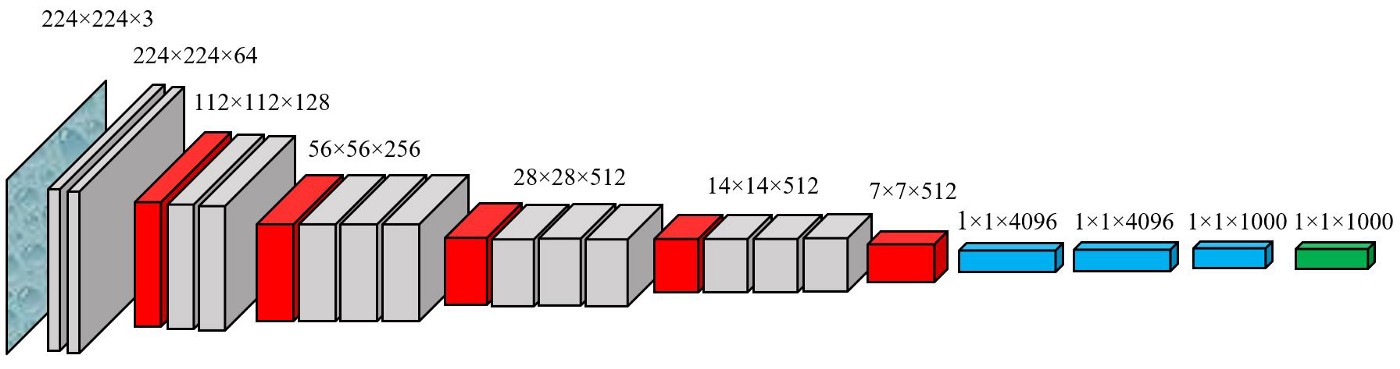

### 4.1 Specifying the Base Model

Transfer learning refers to using a pretrained model on some other task for your own task. Hence we need to specify the particular model which we are deploying in our task and thus needs to specify the base model. In our case we are using the VGG16 model from the Keras.Applications library as the base model.

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet',
                   input_shape=(32, 32, 3), pooling='avg')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

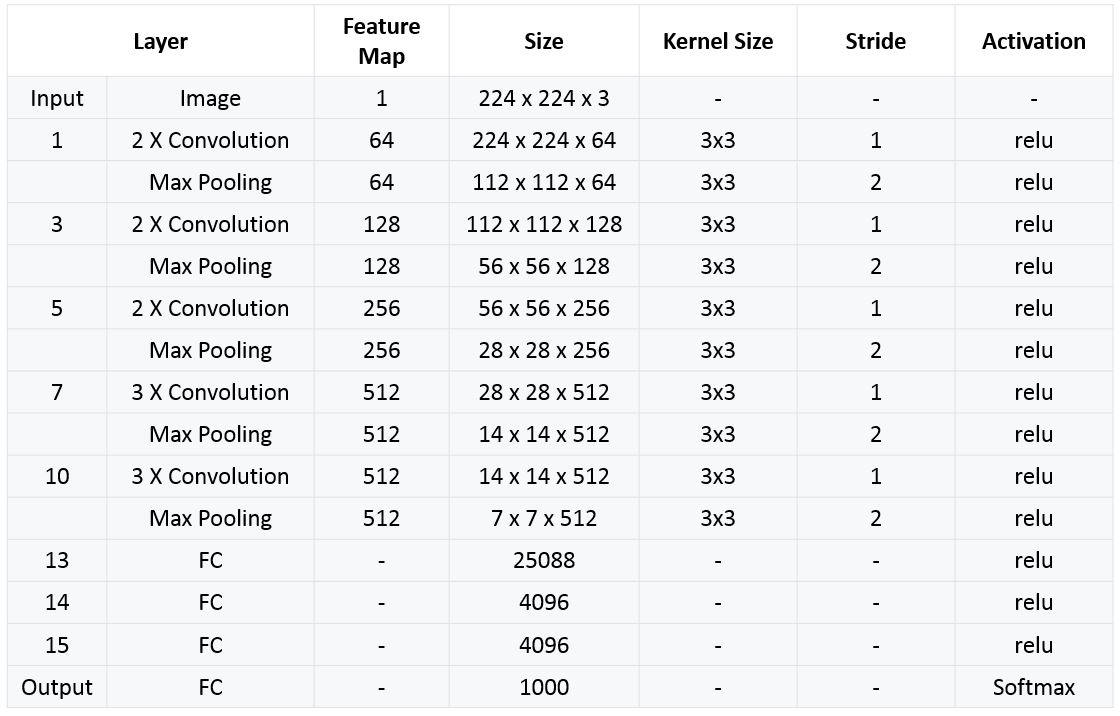

*Note that this is NOT the summary of our model and this is the summary or the ARCHITECTURE of the VGG16 model that we are deploying as the base model.*

### 4.2 Adding our Own Fully Connected Layers

Now we need to add at the top of the base model some fully connected layers.
Alsowe can use the BatchNormalization and the Dropout layers as usual in case we want to.

For this I have used a Keras sequential model and build our entire model on top of it; comprising of the VGG model as the base model + our own fully connected layers.

In [ ]:
vgg16_model = Sequential()
vgg16_model.add(base_model)
vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(Dense(10, activation='softmax'))

vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


### 4.3 Compling & Training the Model

In [ ]:
# To use the pretrained model as a feature extractor and just train your classifier on top of it.
# doing so we won't tune any weights of the base model (vgg16)
base_model.trainable = False

vgg16_model.compile(optimizer=opt_Adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg16_history = vgg16_model.fit(X_train, y_train, batch_size = batch_size,
                    epochs = epochs, validation_data = (X_test, y_test),
                    verbose = 1, steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks=[earlystopper, reduce_lr])

Epoch 1/50
390/390 [==============================] - 10s 25ms/step - loss: 1.8522 - accuracy: 0.3744 - val_loss: 1.5784 - val_accuracy: 0.4601 - lr: 1.0000e-04
Epoch 2/50
390/390 [==============================] - 10s 24ms/step - loss: 1.4800 - accuracy: 0.4975 - val_loss: 1.4290 - val_accuracy: 0.5099 - lr: 1.0000e-04
Epoch 3/50
390/390 [==============================] - 10s 26ms/step - loss: 1.3755 - accuracy: 0.5302 - val_loss: 1.3642 - val_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 4/50
390/390 [==============================] - 9s 23ms/step - loss: 1.3183 - accuracy: 0.5492 - val_loss: 1.3238 - val_accuracy: 0.5459 - lr: 1.0000e-04
Epoch 5/50
390/390 [==============================] - 9s 23ms/step - loss: 1.2782 - accuracy: 0.5624 - val_loss: 1.2957 - val_accuracy: 0.5509 - lr: 1.0000e-04
Epoch 6/50
390/390 [==============================] - 9s 23ms/step - loss: 1.2512 - accuracy: 0.5707 - val_loss: 1.2767 - val_accuracy: 0.5621 - lr: 1.0000e-04
Epoch 7/50
390/390 [=================

Overall performance

In [ ]:
def show_model_history(model_history, model_name):
    history = pd.DataFrame()
    history["Train Loss"] = model_history.history['loss']
    history["Validation Loss"] = model_history.history['val_loss']
    history["Train Accuracy"] = model_history.history['accuracy']
    history["Validation Accuracy"] = model_history.history['val_accuracy']

    fig, axarr = plt.subplots(nrows=2, ncols=1 ,figsize=(12,8))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    history[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    history[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    plt.suptitle(" Convulutional Model {} Loss and Accuracy in Train and Validation Datasets".format(model_name))
    plt.show()
    plt.clf()

    return history

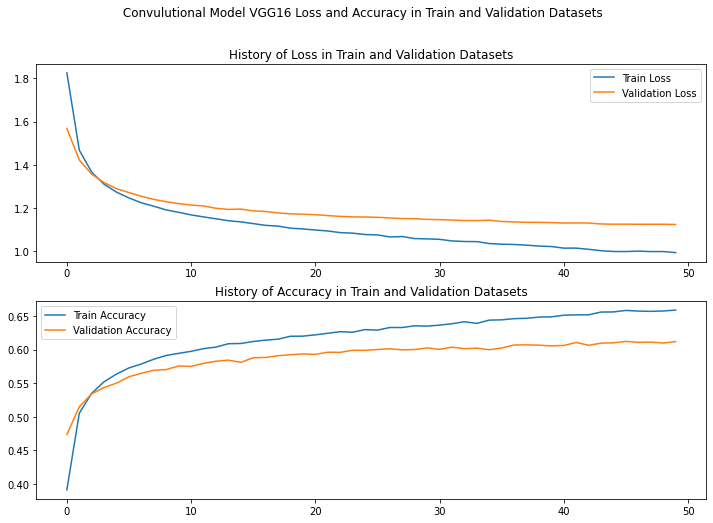

<Figure size 432x288 with 0 Axes>

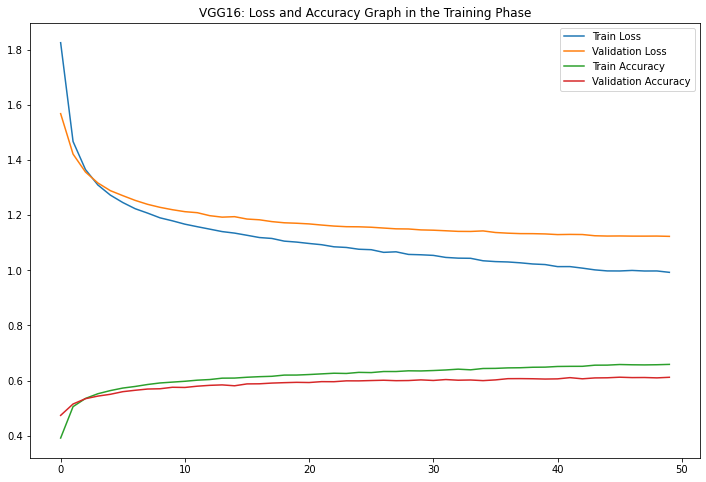

In [ ]:
vgg16_h = show_model_history(model_history=vgg16_history, model_name='VGG16')

vgg16_h.plot(figsize=(12,8))
plt.title("VGG16: Loss and Accuracy Graph in the Training Phase")
plt.show()

## 5 LeNet-5 Architecture

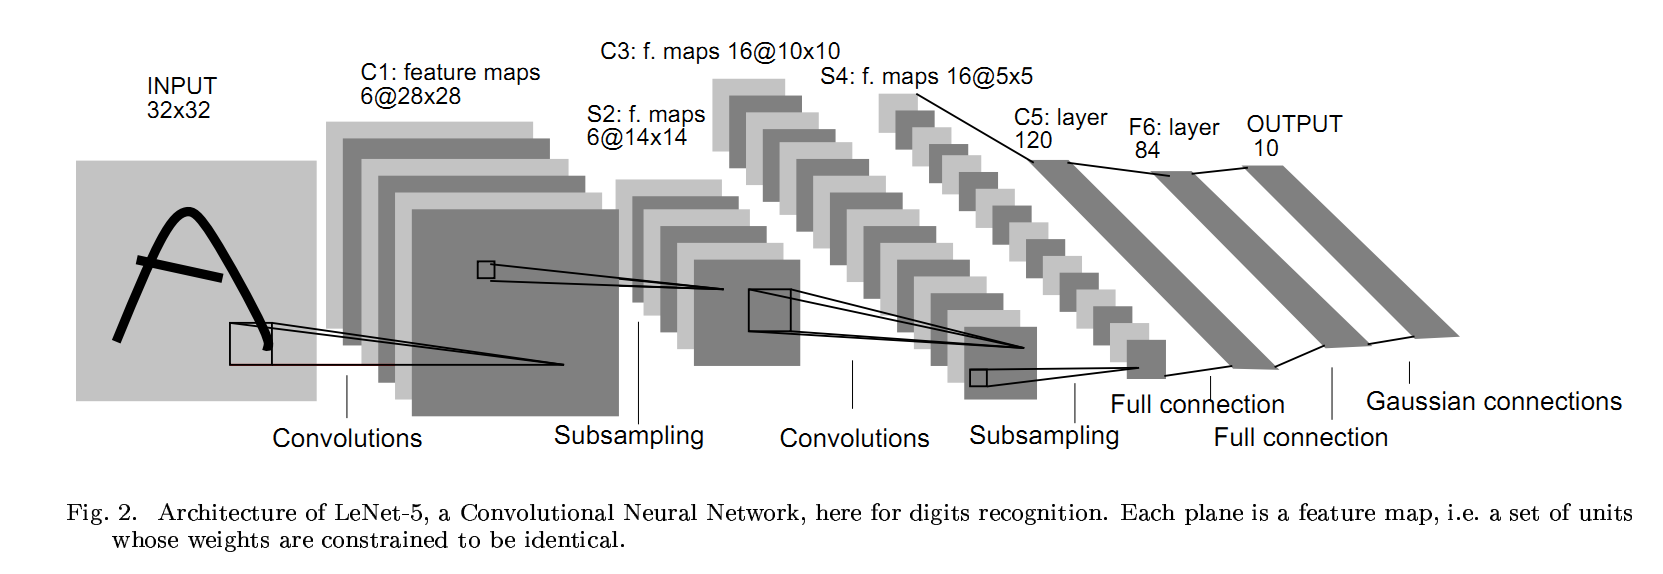

### 5.1 Image Data Preprocessing

In [ ]:
def show_images(cmap: str):
  """
   display the first 21 images in the dataset which are divided into 7 columns and 3 rows.
  """
  fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(17, 8))
  index = 0
  for i in range(3):
      for j in range(7):
          axes[i,j].set_title(class_names[y_ltrain[index][0]])
          axes[i,j].imshow(X_ltrain[index], cmap=cmap)
          axes[i,j].get_xaxis().set_visible(False)
          axes[i,j].get_yaxis().set_visible(False)
          index += 1

  plt.show()

In [ ]:
(X_ltrain, y_ltrain), (X_ltest, y_ltest) = cifar10.load_data() #load_data('/kaggle/input/cifar10-python/cifar-10-batches-py')
print("CIFAR-10 dataset loaded...")

CIFAR-10 dataset loaded...


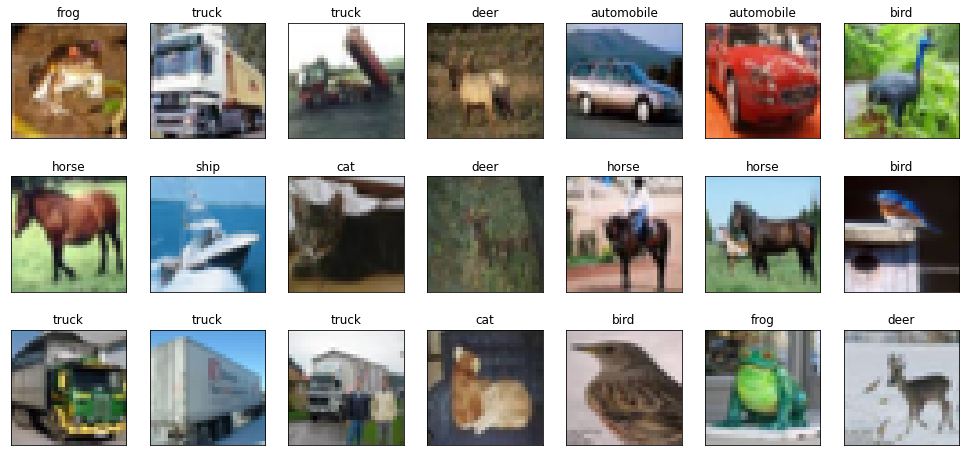

In [ ]:
show_images('cool')

### *Reduce the dimensionality of the data: convert all those images (both train and test data) into grayscale*

In [ ]:
X_ltrain = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_ltrain])
X_ltest = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_ltest])

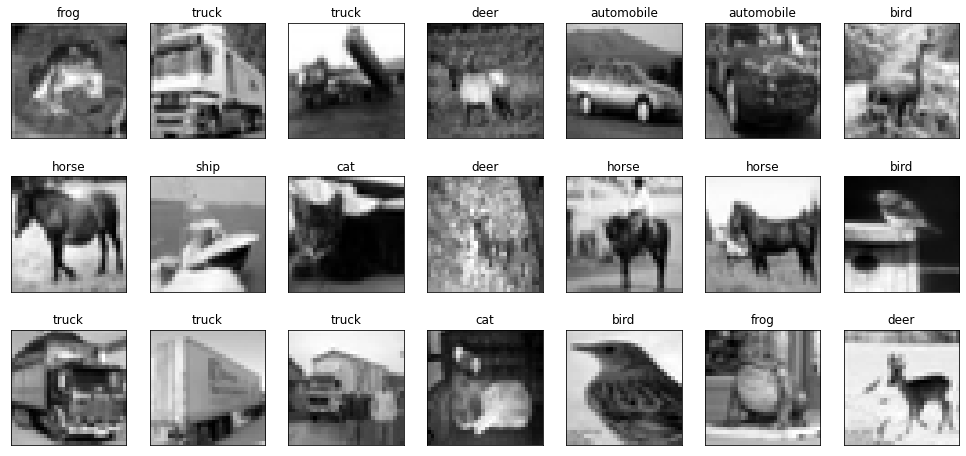

In [ ]:
show_images('gray')

In [ ]:
# Peforming reshaping operation for Conv2D layer (1 color channel (gray))
X_ltrain = X_ltrain.reshape(X_ltrain.shape[0], 32, 32, 1)
X_ltest = X_ltest.reshape(X_ltest.shape[0], 32, 32, 1)

In [ ]:
# Normalization
X_ltrain = X_ltrain / 255
X_ltest = X_ltest / 255

# One Hot Encoding
labelBinarizer = LabelBinarizer()
y_ltrain = labelBinarizer.fit_transform(y_ltrain)
y_ltest = labelBinarizer.transform(y_ltest)

In [ ]:
X_ltrain.shape

(50000, 32, 32, 1)

In [ ]:
X_ltest.shape

(10000, 32, 32, 1)

### 5.2 Summary & Architecture
* LeNet-5 is a very efficient convolutional neural network for handwritten character recognition.
* Convolutional neural networks can make good use of the structural information of images.
* The convolutional layer has fewer parameters, which is also determined by the main characteristics of the convolutional layer, that is, local connection and shared weights.

<img align="center" src="attachment:e3c71f64-651b-40e6-885f-2e93413e25b4.png"/>


In [ ]:
# Building the Model Architecture
lenet_model = Sequential()
# Select 6 feature convolution kernels with a size of 5 * 5 (without offset), and get 66 feature maps.
# The size of each feature map is 32−5 + 1 = 28
# That is, the number of neurons has been reduced from 32 * 32 = 1024 to 28 ∗ 28 = 784
# Parameters between input layer and C1 layer: 6 ∗ (5 ∗ 5 + 1)
lenet_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)))

# The input of this layer is the output of the first layer, which is a 28 * 28 * 6 node matrix.
# The size of the filter used in this layer is 2 * 2, and the step length and width are both 2, so the output matrix size of this layer is 14 * 14 * 6.
lenet_model.add(MaxPooling2D(pool_size=(2, 2)))

# The input matrix size of this layer is 14 * 14 * 6, the filter size used is 5 * 5, and the depth is 16. This layer does not use all 0 padding, and the step size is 1.
# The output matrix size of this layer is 10 * 10 * 16. This layer has 5 * 5 * 6 * 16 + 16 = 2416 parameters
lenet_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))

# The input matrix size of this layer is 10 * 10 * 16. The size of the filter used in this layer is 2 * 2, and the length and width steps are both 2, so the output matrix size of this layer is 5 * 5 * 16.
lenet_model.add(MaxPooling2D(pool_size=(2, 2)))

# The input matrix size of this layer is 5 * 5 * 16. This layer is called a convolution layer in the LeNet-5 paper, but because the size of the filter is 5 * 5, #
# So it is not different from the fully connected layer. If the nodes in the 5 * 5 * 16 matrix are pulled into a vector, then this layer is the same as the fully connected layer.
# The number of output nodes in this layer is 120, with a total of 5 * 5 * 16 * 120 + 120 = 48120 parameters.
lenet_model.add(Flatten())

lenet_model.add(Dense(120, activation='relu'))
# The number of input nodes in this layer is 120 and the number of output nodes is 84. The total parameter is 120 * 84 + 84 = 10164 (w + b)
lenet_model.add(Dense(84, activation='relu'))
# The number of input nodes in this layer is 84 and the number of output nodes is 10. The total parameter is 84 * 10 + 10 = 850
lenet_model.add(Dense(10, activation='softmax'))

In [ ]:
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 120)              

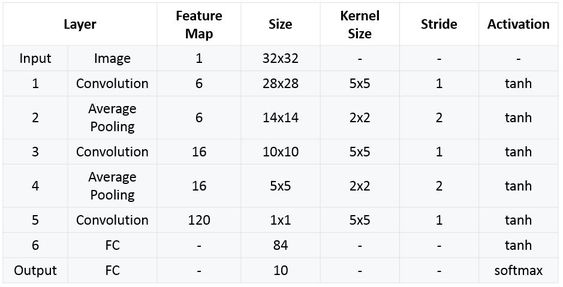

### 5.2 Compling & Training LeNet

In [ ]:
lenet_model.compile(optimizer=opt_SGD, loss='categorical_crossentropy', metrics=['accuracy'])

lenet_history = lenet_model.fit(X_ltrain, y_ltrain, batch_size=batch_size,
                                epochs=epochs, verbose=1,
                                validation_data=(X_ltest, y_ltest),
                                callbacks=[earlystopper, reduce_lr])

Epoch 1/50
391/391 [==============================] - 3s 5ms/step - loss: 2.0158 - accuracy: 0.2646 - val_loss: 1.7219 - val_accuracy: 0.3805 - lr: 0.0100
Epoch 2/50
391/391 [==============================] - 2s 4ms/step - loss: 1.6491 - accuracy: 0.4075 - val_loss: 1.5984 - val_accuracy: 0.4258 - lr: 0.0100
Epoch 3/50
391/391 [==============================] - 2s 4ms/step - loss: 1.5255 - accuracy: 0.4547 - val_loss: 1.4838 - val_accuracy: 0.4660 - lr: 0.0100
Epoch 4/50
391/391 [==============================] - 2s 4ms/step - loss: 1.4351 - accuracy: 0.4903 - val_loss: 1.4229 - val_accuracy: 0.4936 - lr: 0.0100
Epoch 5/50
391/391 [==============================] - 2s 4ms/step - loss: 1.3551 - accuracy: 0.5204 - val_loss: 1.3538 - val_accuracy: 0.5175 - lr: 0.0100
Epoch 6/50
391/391 [==============================] - 2s 5ms/step - loss: 1.2855 - accuracy: 0.5480 - val_loss: 1.3185 - val_accuracy: 0.5265 - lr: 0.0100
Epoch 7/50
391/391 [==============================] - 2s 5ms/step - lo

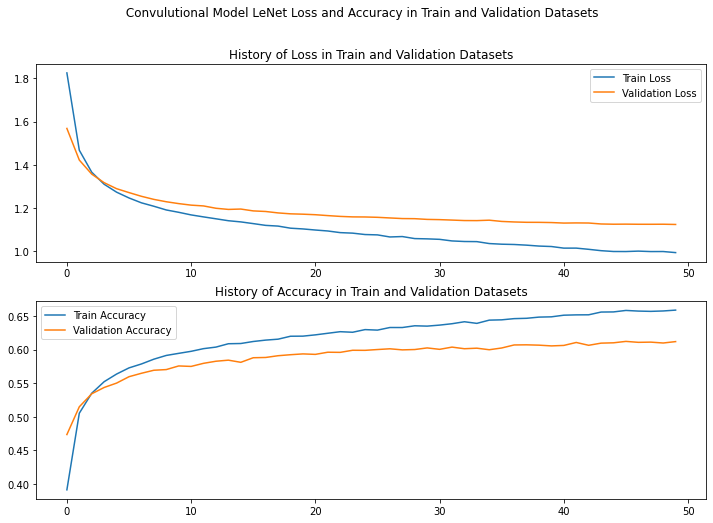

<Figure size 432x288 with 0 Axes>

In [ ]:
lenet_hist = show_model_history(model_history=vgg16_history, model_name='LeNet')

#### *Model behavior can be examined by observing the success and loss rates of the training and test data sets.*

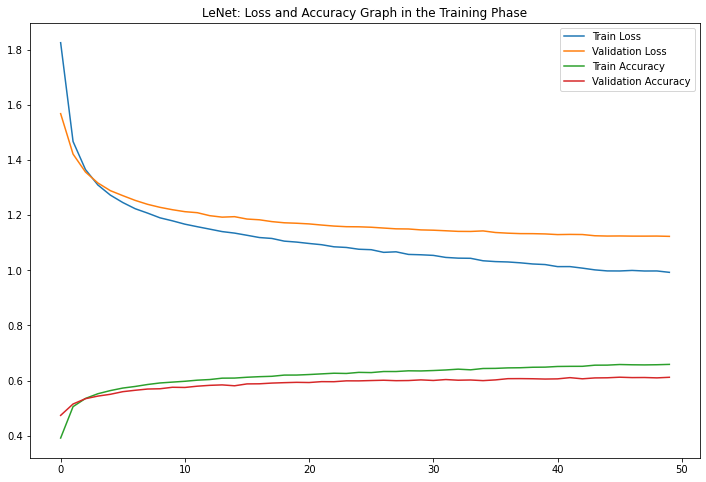

In [ ]:
lenet_hist.plot(figsize=(12,8))
plt.title("LeNet: Loss and Accuracy Graph in the Training Phase")
plt.show()

## 6 Comparing the two models
Now, let's compare the network architecture and the performance of our two models.

### 6.1 Let's compare accuracy, classification report and the confusion matrix

In [ ]:
vgg16_predictions = vgg16_model.predict(X_test, batch_size=256)
lenet_predictions = lenet_model.predict(X_ltest, batch_size=256)
print("Predictions was performed on the test data set...")


Predictions was performed on the test data set...


In [ ]:
# Classification results
def compute_and_show_pred(predictions, test_label):
  #1 these predictions are still in form of probability distribution of each class,
  # hence we need to transform the values to its predicted label in form of a single number encoding instead.
  acc_score = accuracy_score(test_label.argmax(axis=1), predictions.argmax(axis=1))
  print("Accuracy score:",acc_score)
  #2
  cr = classification_report(test_label.argmax(axis=1),
                             predictions.argmax(axis=1),
                             target_names=class_names)
  print("Classification Report:")
  print(cr)
  #3
  cm = confusion_matrix(test_label.argmax(axis=1), predictions.argmax(axis=1))
  plt.figure(figsize=(12,12))
  sns.heatmap(cm, annot=True,   # Seaborn 🌊 visualization
              xticklabels=class_names,
              yticklabels=class_names,
              fmt="d")
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  print("Confusion Matrix:\n")
  plt.show()

Accuracy score: 0.6062
Classification Report:
              precision    recall  f1-score   support

    airplane       0.67      0.69      0.68      1000
  automobile       0.65      0.69      0.67      1000
        bird       0.55      0.48      0.51      1000
         cat       0.45      0.43      0.44      1000
        deer       0.56      0.52      0.54      1000
         dog       0.56      0.52      0.54      1000
        frog       0.60      0.72      0.66      1000
       horse       0.66      0.67      0.66      1000
        ship       0.71      0.72      0.71      1000
       truck       0.62      0.62      0.62      1000

    accuracy                           0.61     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.60      0.61      0.60     10000

Confusion Matrix:



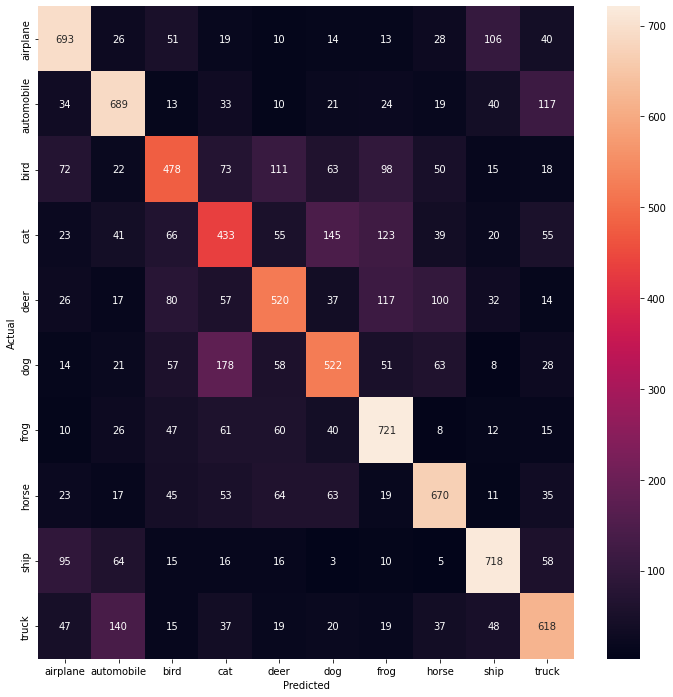

In [ ]:
compute_and_show_pred(vgg16_predictions, y_test)

Accuracy score: 0.6324
Classification Report:
              precision    recall  f1-score   support

    airplane       0.67      0.67      0.67      1000
  automobile       0.72      0.76      0.74      1000
        bird       0.53      0.48      0.50      1000
         cat       0.44      0.40      0.42      1000
        deer       0.55      0.57      0.56      1000
         dog       0.55      0.54      0.54      1000
        frog       0.68      0.73      0.70      1000
       horse       0.70      0.71      0.71      1000
        ship       0.74      0.75      0.74      1000
       truck       0.71      0.71      0.71      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000

Confusion Matrix:



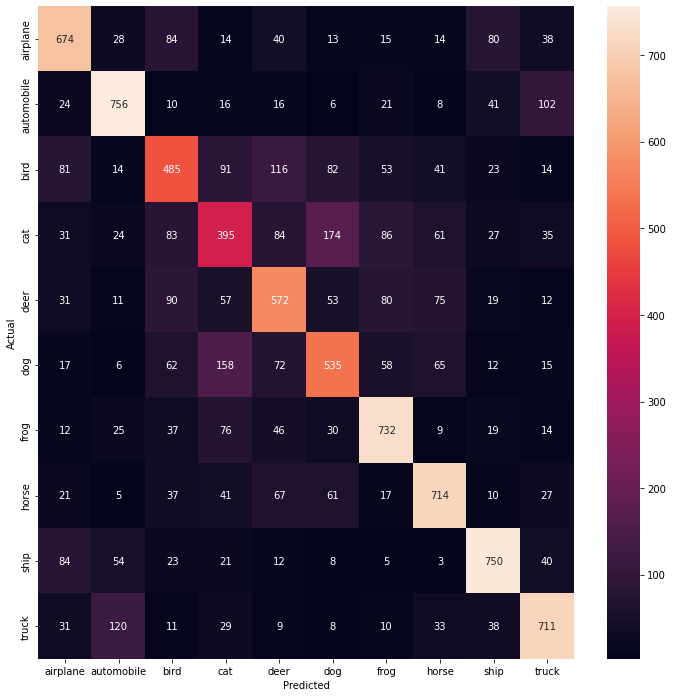

In [ ]:
compute_and_show_pred(lenet_predictions, y_ltest)

## 7 Brief summary

### VGG16

Pros:

* Solid model, with the concept of grouping multiple convolution layers.
* Came in 2014, and results were amazing if you look it in perspective of 2014, went on to score 92.7% on ImageNet.
* Pretrain and Transfer learning delivers okay performances

Cons:

* Large number of weights parameters, close to 550MB in size, leading to model being large in size.
* High Inference Time.


**why not make the model deeper?**

VGG-19 is there as well. But the moment, you look for more layers, deeper the network gets, more heavier the model is, more inference time is there, suffers from vanishing gradient problem. If your model is simple like VGG-16 and contains large number of layers will have higher test error and generalize lesser.

### LeNet-5

LeNet-5 architecture is very easy and simple to understand. It consists of 2 sets of convolutional and average pooling layers, followed by a flattening convolutional layer, then two fully-connected layers, and finally a softmax classifier.

Pros:

* Light and easy to train, It works well for character recognition images like Mnist
* 60000+ parameters

Cons:

* The input to the model is a grayscale image.
* Since isn't very deep, it struggles to scan for all features thus producing poor performing models